<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/exmples/experiments/molecule_RNN_test_08_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/shiwentao00/Molecule-RNN.git --quiet

In [2]:
! pip install rdkit --quiet
! pip install selfies --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 42.0 MB/s eta 0:00:00


In [2]:
cd Molecule-RNN

/content/Molecule-RNN


In [1]:
import torch
import re
from tqdm import tqdm
import yaml
import selfies as sf
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# import yaml
import os
# import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
# import selfies as sf
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [3]:
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

class SELFIEVocab:
    def __init__(self, vocab_path):
        self.name ='selfies'
        with open(vocab_path, 'r') as f: self.vocab = yaml.full_load(f)
        self.int2token = {value:key for key, value in self.vocab.items()}
    def tokenize_smiles(self, mol): #mol is selfie actually
        ints = [self.vocab['<sos>']]
        selfies_list = list(sf.split_selfies(mol))
        ints += [self.vocab[token] for token in selfies_list]
        ints.append(self.vocab['<eos>'])
        return ints
    def combine_list(self, selfies): return "".join(selfies)

import pandas as pd

class SMILESDataset(Dataset):
    def __init__(self, smiles_file, percentage, vocab):
        super(SMILESDataset, self).__init__()
        assert (0<percentage<=1)
        self.percentage = percentage
        self.vocab = vocab
        if smiles_file.split('.')[-1] == 'smi':
            self.data = self.read_smiles_file(smiles_file)
        elif smiles_file.split('.')[-1] == 'csv':
            self.data = self.read_csv_file(smiles_file)
        print('total number of SMILES loaded: ', len(self.data))

        if self.vocab.name == 'selfies':
            self.data = self.smi2sf()
            print('total valid SELFIES:', len(self.data))
    def __getitem__(self, index):
        s_mol = self.data[index]
        vec_mol = self.vocab.tokenize_smiles(s_mol)
        return vec_mol

    def __len__(self): return len(self.data)

    def smi2sf(self):
        smiles = self.data
        sfs = []
        for i in tqdm(smiles, total=len(smiles)):
            try:
                s_ = sf.encoder(i)
                if s_ is not None: sfs.append(s_)
            except: pass
        return sfs



    def read_smiles_file(self, path):
        with open(path, 'r') as f:
            smiles = [line.strip("\n") for line in f.readlines()]
        num_data = len(smiles)
        return smiles[0:int(num_data*self.percentage)]

    def read_csv_file(self, path):
        data = pd.read_csv(path)
        for i in ['Smiles', 'smiles', 'SMILES']:
            if i in data.columns:
                smiles = data[i].tolist()
                num_data = len(smiles)
                return smiles[0:int(num_data*self.percentage)]

smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

def dataloader_gen(percentage, batch_size, PADDING_IDX, shuffle,
                   dataset_dir=smile_dir, which_vocab='selfies',
                   vocab_path=selfie_vocab_path, drop_last=True):
    print('which_vocab:', which_vocab)
    if which_vocab == 'selfies':
        vocab = SELFIEVocab(vocab_path)
        dataset = SMILESDataset(dataset_dir, percentage, vocab)
    else:
        dataset = None
        vocab = None

    def pad_collate(batch):
        lengths = [len(x) for x in batch]
        batch = [torch.tensor(x, dtype=torch.long) for x in batch]
        x_padded = pad_sequence(batch, batch_first=True,
                                padding_value=PADDING_IDX)
        return x_padded, lengths

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last,
                            collate_fn=pad_collate)
    return dataloader, len(dataset)


In [4]:
rnn_config = {
    'num_embeddings': 78,
    'embedding_dim': 256,
    'rnn_type': "GRU",

    "input_size": 256,
    'hidden_size': 512,
    'num_layers': 3,
    'dropout': 0,

    "batch_size": 512,
    'shuffle': True,
    'num_epoch': 10,
    'which_optimizer': 'adam',
    'learning_rate': 0.001,
    'weight_decay': 1.0e-4
}


In [5]:

def sample(model, vocab, batch_size):
    model.eval()
    sample_ints = model.sample(batch_size=batch_size, vocab=vocab).tolist()
    molecules = []
    for ints in sample_ints:
        mol = []
        for x in ints:
            if vocab.int2token[x] == '<eos>': break
            else: mol.append(vocab.int2token[x])
        string_mol = "".join(mol)
        molecules.append(string_mol)
    if vocab.name == 'selfies':
        molecules = [sf.decoder(x) for x in molecules]
    return molecules


def compute_valid_rate(molecules):
    num_valid, num_invalid = 0, 0
    valid_mols = set()
    for i in molecules:
        mol = Chem.MolFromSmiles(i)
        if mol is None: num_invalid +=1
        else:
            num_valid += 1
            valid_mols.add(i)
    assert len(molecules) == num_valid + num_invalid
    unique_num = len(valid_mols)
    # print(unique_num)
    valid_rate = num_valid / len(molecules)
    unique_rate = unique_num / len(molecules)
    return valid_rate, unique_rate

import torch
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    cuda = torch.cuda.is_available()
    if cuda: device = 'cuda'
    else: device = 'cpu'
    model.load_state_dict(torch.load(path, map_location=device))

In [6]:
cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'

out_dir = 'model_save/'
if not os.path.exists(out_dir): os.makedirs(out_dir)

with open(out_dir+'config.yaml', 'w') as f: yaml.dump(rnn_config, f)

smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

In [7]:
print(rnn_config)
dataset_dir = smile_dir
which_vocab = 'selfies'
vocab_path = selfie_vocab_path

batch_size = rnn_config['batch_size']
shuffle = rnn_config['shuffle']
PADDING_IDX = rnn_config['num_embeddings']-1
num_workers = os.cpu_count()
print('number of workers to load data:', num_workers)
print('which vocab to use: ', which_vocab)
vocab = SELFIEVocab(selfie_vocab_path)

{'num_embeddings': 78, 'embedding_dim': 256, 'rnn_type': 'GRU', 'input_size': 256, 'hidden_size': 512, 'num_layers': 3, 'dropout': 0, 'batch_size': 512, 'shuffle': True, 'num_epoch': 10, 'which_optimizer': 'adam', 'learning_rate': 0.001, 'weight_decay': 0.0001}
number of workers to load data: 8
which vocab to use:  selfies


In [8]:
percentage = 0.01

dataloader, train_size = dataloader_gen(percentage, batch_size, PADDING_IDX,
                                        shuffle, drop_last=False)

which_vocab: selfies
total number of SMILES loaded:  5382


100%|██████████| 5382/5382 [00:03<00:00, 1669.58it/s]

total valid SELFIES: 5382


In [9]:
sos = torch.ones([batch_size, 1], dtype=torch.long, device=device)

In [10]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.functional import softmax
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, rnn_config):
        super(RNN, self).__init__()

        self.emb = nn.Embedding(num_embeddings = rnn_config['num_embeddings'],
                                embedding_dim = rnn_config['embedding_dim'],
                                padding_idx = rnn_config['num_embeddings'] - 1)

        if rnn_config['rnn_type'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = rnn_config['input_size'],
                               hidden_size = rnn_config['hidden_size'],
                               num_layers = rnn_config['num_layers'],
                               batch_first=True, dropout=rnn_config['dropout'])
        elif rnn_config['rnn_type'] == 'GRU':
            self.rnn = nn.GRU(input_size = rnn_config['input_size'],
                            hidden_size = rnn_config['hidden_size'],
                            num_layers = rnn_config['num_layers'],
                            batch_first=True, dropout=rnn_config['dropout'])
        else: raise ValueError('rnn_type should be LSTM or GRU')
        hid_dim = int(rnn_config['hidden_size']/2)
        self.linear = nn.Linear(rnn_config['hidden_size'], hid_dim)

        self.mu = nn.Linear(hid_dim, hid_dim)

        self.decode = nn.Linear(hid_dim, rnn_config['num_embeddings']-2)

    def forward(self, data, lengths):
        # print('data shape: ', data.shape) # [batch_size, ...]
        embeddings = self.emb(data)
        # print('emb shape:', embeddings.shape) #[batch_size, ..., embedding_dim]
        # emb before pack:               torch.Size([512, 115 (can change), 256])


        embeddings = pack_padded_sequence(input=embeddings, lengths=lengths,
                                    batch_first=True, enforce_sorted=False)



        # print('emb after pack: ', embeddings.shape)
        # cannot shape pack_padded sequence

        embeddings, _ = self.rnn(embeddings)
        # print('emb after rnn: ', embeddings.shape)
        # AttributeError: 'PackedSequence' object has no attribute 'shape'

        embeddings = self.linear(embeddings.data)


        # print('emb after linear: ', embeddings.shape)
        # [sum_of_mol_len, num_embedding-2]

        embeddings = self.mu(embeddings)
        embeddings = F.relu(embeddings)
        return self.decode(embeddings)

    def sample(self, batch_size, vocab, max_length=140):
        start_int = vocab.vocab['<sos>']
        if torch.cuda.is_available(): device='cuda'
        else: device = 'cpu'
        sos = torch.ones([batch_size, 1], dtype=torch.long, device=device)
        sos = sos * start_int
        output = []
        x = self.emb(sos)

        x, hidden = self.rnn(x)
        x = self.linear(x)
        x = F.relu(self.mu(x))
        x = self.decode(x)
        x = softmax(x, dim=-1)
        x = torch.multinomial(x.squeeze(), 1)
        output.append(x)
        # x = sos
        finish = torch.zeros(batch_size, dtype=torch.bool).to(device)
        for _ in range(max_length):
            x = self.emb(x)
            x, hidden = self.rnn(x, hidden)
            x = self.linear(x)
            x = F.relu(self.mu(x))
            x = self.decode(x)
            x = softmax(x, dim=-1)

            x = torch.multinomial(x.squeeze(), 1)
            output.append(x)
            eos_sampled = (x==vocab.vocab['<eos>']).data
            finish = torch.logical_or(finish, eos_sampled.squeeze())
            if torch.all(finish):
                return torch.cat(output, -1)
        return torch.cat(output, -1)

In [11]:
model = RNN(rnn_config).to(device)
learning_rate = rnn_config['learning_rate']
weight_decay = rnn_config['weight_decay']
loss_function = nn.CrossEntropyLoss(reduction='sum')

if rnn_config['which_optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
elif rnn_config['which_optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                weight_decay=weight_decay, momentum=0.9)
elif rnn_config['which_optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
else: raise ValueError('wrong optimizer. should be adam, sgd or adamw')

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              cooldown=10, min_lr=1e-4, verbose=True)

In [12]:
train_losses = []
best_valid_rate = 0
num_epoch = rnn_config['num_epoch']
print(f'begin training {num_epoch} epochs')
model_names = []
best_epoch = 0

begin training 10 epochs


In [15]:
if best_epoch != 0:
    load_model(model, out_dir + f'epoch_{best_epoch}.pt')

# device = 'cuda'

for epoch in range(1, 1+num_epoch):
    model.train()
    train_loss = 0
    for data, lengths in tqdm(dataloader, total=len(dataloader),
                              desc=f'epoch {epoch}'): # batch_size = 512
        # print(lengths)
        lengths = [l-1 for l in lengths]
        optimizer.zero_grad()
        if cuda: data = data.cuda()
        # data = data.to(device)
        preds = model(data, lengths)
        # print(preds.shape)

        targets = pack_padded_sequence(
            data[:, 1:], lengths, batch_first=True, enforce_sorted=False).data
        # targets = data


        # preds: [num, len_alphabet-2], target: [num]
        # print('hre pred, target, ', preds.shape, targets.shape)
        # preds = preds.view(-1, preds.shape[-1])
        # targets = data
        # targets = targets.reshape(-1)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/train_size)
    print(f'epoch {epoch}, train_loss: {train_losses[-1]:.3f}')
    scheduler.step(train_losses[-1])

    sampled_molecules = sample(model, vocab, batch_size=1024)
    valid, unique = compute_valid_rate(sampled_molecules)
    print(f'valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
    if valid > best_valid_rate:
        best_epoch = epoch
        trained_model_dir = out_dir + f'epoch_{epoch}.pt'
        print(f'save model: ', trained_model_dir)
        save_model(model, trained_model_dir)
        model_names.append(trained_model_dir)
        while len(model_names) > 10:
            try:
                remove_name = model_names.pop(0)
                print('remove ', remove_name)
                os.remove(remove_name)
            except: print(f'error remove {model_names[0]}')


epoch 1: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]


epoch 1, train_loss: 83.514
valid:  100.000 % | unique: 96.777 %
save model:  model_save/epoch_1.pt


epoch 2: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]


epoch 2, train_loss: 81.194
valid:  100.000 % | unique: 97.168 %
save model:  model_save/epoch_2.pt


epoch 3: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


epoch 3, train_loss: 79.878
valid:  100.000 % | unique: 98.438 %
save model:  model_save/epoch_3.pt


epoch 4: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


epoch 4, train_loss: 77.031
valid:  100.000 % | unique: 98.438 %
save model:  model_save/epoch_4.pt


epoch 5: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


epoch 5, train_loss: 75.080
valid:  100.000 % | unique: 98.730 %
save model:  model_save/epoch_5.pt


epoch 6: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]


epoch 6, train_loss: 73.271
valid:  100.000 % | unique: 99.414 %
save model:  model_save/epoch_6.pt


epoch 7: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


epoch 7, train_loss: 71.706
valid:  100.000 % | unique: 99.316 %
save model:  model_save/epoch_7.pt


epoch 8: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


epoch 8, train_loss: 71.171
valid:  100.000 % | unique: 99.609 %
save model:  model_save/epoch_8.pt


epoch 9: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


epoch 9, train_loss: 69.682
valid:  100.000 % | unique: 99.512 %
save model:  model_save/epoch_9.pt


epoch 10: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]


epoch 10, train_loss: 68.128
valid:  100.000 % | unique: 99.414 %
save model:  model_save/epoch_10.pt


  0%|          | 0/3 [00:00<?, ?it/s]


 valid:  100.000 % | unique: 99.805 %


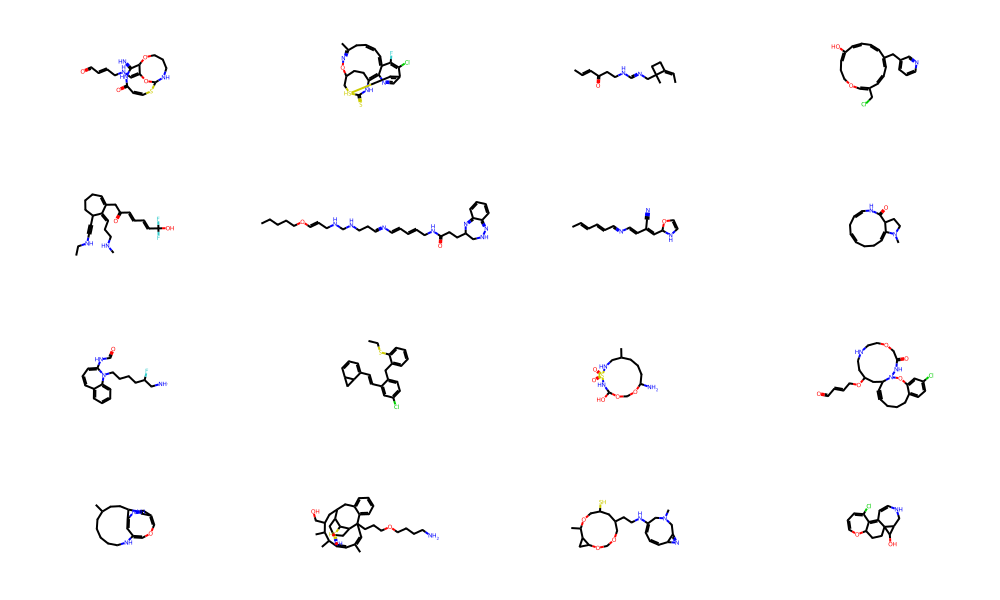

 33%|███▎      | 1/3 [00:00<00:01,  1.68it/s]


 valid:  100.000 % | unique: 99.805 %


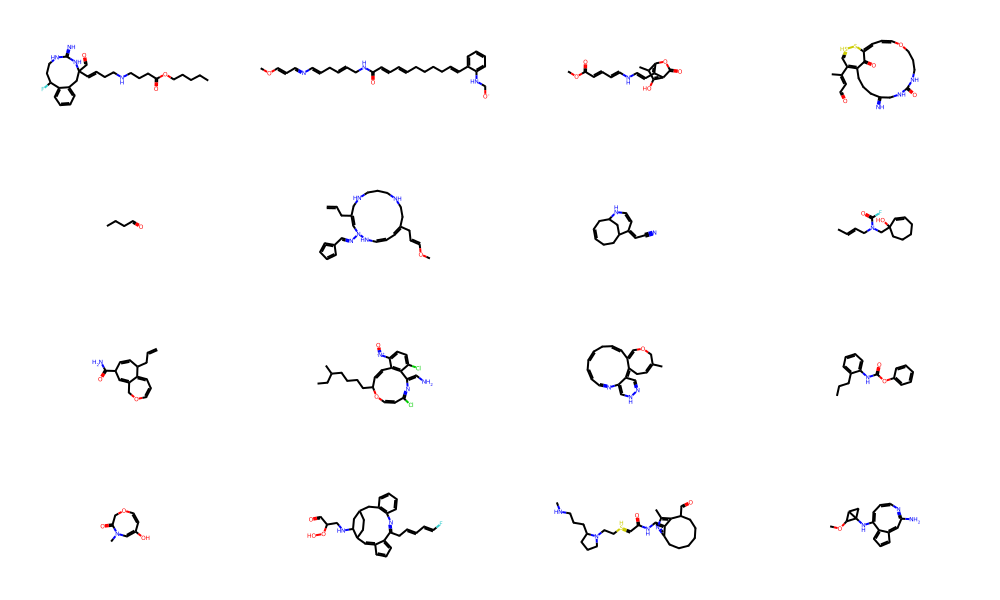

 67%|██████▋   | 2/3 [00:01<00:00,  1.87it/s]


 valid:  100.000 % | unique: 100.000 %


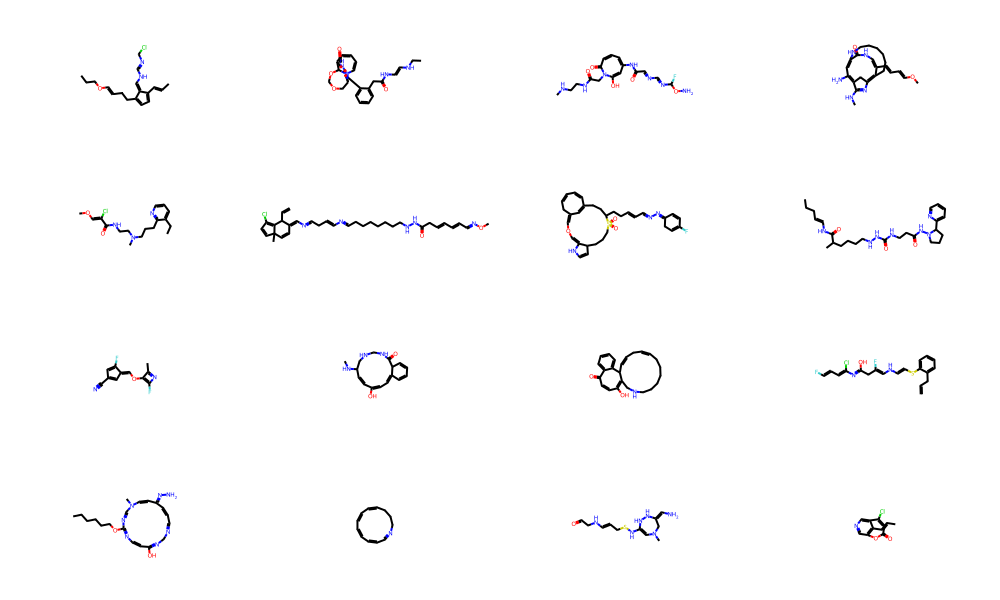

100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


In [62]:
best_dir = out_dir + f'epoch_{best_epoch}.pt'
with open(out_dir +'config.yaml', 'r') as f: config = yaml.full_load(f)
model = RNN(config).to(device)
load_model(model, best_dir)
model.eval()
num_batches = 3
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import random
import math
from rdkit import Chem
mol_conv = Chem.MolFromSmiles

for _ in tqdm(range(num_batches)):
    sampled_ints = model.sample(batch_size=batch_size,
                                vocab=vocab).tolist()
    mols = []
    for ints in sampled_ints:
        s_mol = []
        for x in ints:
            if vocab.int2token[x] =='<eos>':break
            else: s_mol.append(vocab.int2token[x])
        mols.append("".join(s_mol))
    mols = [sf.decoder(x) for x in mols]
    valid, unique = compute_valid_rate(mols)
    print(f'\n valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
    all_correct_molecules = set(mols)
    MAX_GRID = 16
    show_num = min(len(all_correct_molecules), MAX_GRID)
    selected_smiles = random.choices([*all_correct_molecules], k=show_num)
    molecules = [mol_conv(i) for i in selected_smiles]

    img = MolsToGridImage(
        [m for m in molecules if m is not None],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)


52

 valid:  100.000 % | unique: 100.000 %
['CC1=CC(O)CC1C(C)C2C=CC(O)=CC(=O)OC=N2', 'CC(CCCC(C)CC)CCNCCNCCC(=O)NC=C1N=C[NH1]C=CC=CC1C']


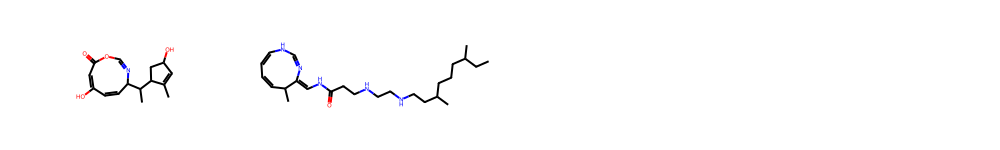

In [117]:
sampled_ints = model.sample(batch_size=2, vocab=vocab).tolist()
print(len(sampled_ints[1]))
mols = []
for ints in sampled_ints:
    s_mol = []
    for x in ints:
        if vocab.int2token[x] =='<eos>':break
        else: s_mol.append(vocab.int2token[x])
    mols.append("".join(s_mol))
mols = [sf.decoder(x) for x in mols]
valid, unique = compute_valid_rate(mols)
print(f'\n valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
all_correct_molecules = set(mols)
MAX_GRID = 16
show_num = min(len(all_correct_molecules), MAX_GRID)
selected_smiles = random.choices([*all_correct_molecules], k=show_num)
molecules = [mol_conv(i) for i in selected_smiles]
print(selected_smiles)
img = MolsToGridImage(
    [m for m in molecules if m is not None],
    molsPerRow=int(math.sqrt(MAX_GRID)),
    subImgSize=(250, 150),  returnPNG=False)
display(img)

tensor([[14],
        [14],
        [26],
        [17],
        [63],
        [39],
        [39],
        [14],
        [39],
        [14]], device='cuda:0')
141

 valid:  100.000 % | unique: 100.000 %


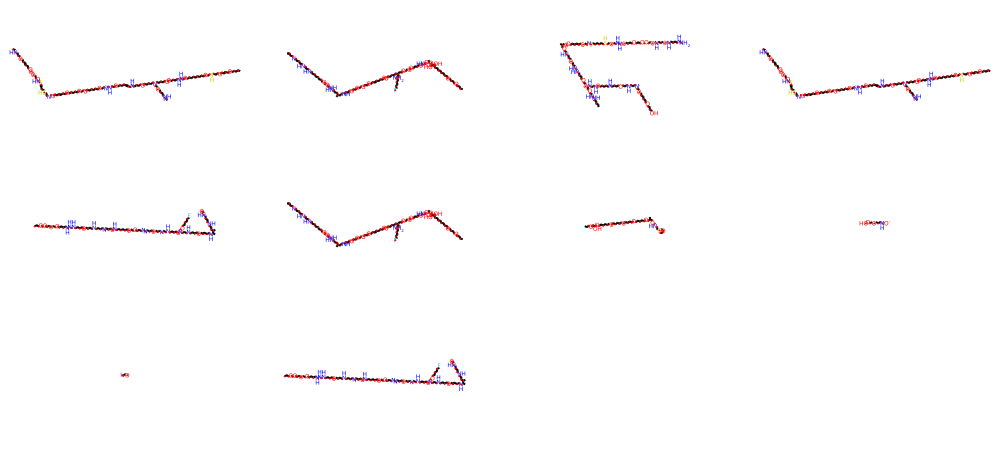

In [128]:
out = []
model.eval()
sample_size = 10
a = torch.ones([sample_size, 1], dtype=torch.long, device='cuda')
a = a * vocab.vocab['<sos>']

x = model.emb(a)  # []
# print(x.shape)
x, hidden =  model.rnn(x)
x = model.linear(x)
x = F.relu(model.mu(x))
x = model.decode(x)
x = softmax(x, dim=-1)

x = torch.multinomial(x.squeeze(), 1)
# x
out.append(x)
finish = torch.zeros(sample_size, dtype=torch.bool).to('cuda')

for _ in range(140):
    if sample_size == 1: x = x.reshape(1, 1)
    # print(x.shape)
    x = model.emb(x)  # []
    x, _ =  model.rnn(x, hidden)
    x = model.linear(x)
    x = F.relu(model.mu(x))
    x = model.decode(x)
    x = softmax(x, dim=-1)
    x = torch.multinomial(x.squeeze(), 1)
    out.append(x)

    eos_sampled = (x==vocab.vocab['<eos>']).data
    # print(eos_sampled.shape)
    finish = torch.logical_or(finish, eos_sampled.squeeze())
    # print(finish)
    if torch.all(finish):
        if sample_size != 1: a = torch.cat(out, 1).tolist()
        else: a = torch.cat(out).tolist()
a = [torch.cat(out).tolist()] if sample_size == 1 else torch.cat(out, 1).tolist()
# a.shape
# a = torch.cat(out, 1).tolist()
print(len(a[0]))
mols = []




for ints in a:
    s_mol = []
    for x in ints:
        if vocab.int2token[x] =='<eos>':break
        else: s_mol.append(vocab.int2token[x])
        # print(s_mol)
    mols.append("".join(s_mol))

mols = [sf.decoder(x) for x in mols]

valid, unique = compute_valid_rate(mols)
print(f'\n valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
all_correct_molecules = set(mols)
MAX_GRID = 16
show_num = min(len(all_correct_molecules), MAX_GRID)
selected_smiles = random.choices([*all_correct_molecules], k=show_num)
molecules = [mol_conv(i) for i in selected_smiles]

img = MolsToGridImage(
    [m for m in molecules if m is not None],
    molsPerRow=int(math.sqrt(MAX_GRID)),
    subImgSize=(250, 150),  returnPNG=False)
display(img)

141
['[=O][SH1][Ring2][Se+1][#Branch1][O-1][#N+1][=O][P][=O][#Branch2][=P][OH0][#N+1][S-1][=Se][#N][BH1-1][S][O+1][=N+1][#Branch2][B-1][#C][B-1][S][P+1][I][=Te+1][Cl][Branch2][C+1][#N+1][Cl+3][I+1][NH2+1][B-1][=SH1][Ring1][=SH1][NH1-1][Ring1][=S+1][=O+1][SH1][=PH1][O+1][#N+1][Ring1][SH1][BH3-1][C+1][OH0][#C][Te][F][S+1][Al][N][=N][Branch1][BH3-1][=S+1][#C][=S][#Branch2][=Te+1][N-1][=As][S-1][Branch2][Na][O-1][B-1][N][C][OH0][Si][O+1][B-1][F][BH2-1][SeH1][#N][=Te+1][=S+1][Se+1][NH2+1][=SH1][OH1+1][PH1][=P+1][C+1][=NH1+1]', '[Ring2][B][Se][C-1][Na][Al][BH1-1][BH1-1][=Branch1][Branch2][BH2-1][Branch2][=Se+1][#Branch2][BH3-1][#Branch1][Si][BH1-1][=Branch1][BH1-1][=S][O+1][OH1+1][#Branch2][SH1][OH0][P][B][=P][Cl+3][#N+1][Ring2][F][NH1+1][P+1][#Branch2][N-1][=P+1][=Se+1][N+1][N-1][=SH1][Branch2][C][P+1][#N+1][F][B-1][N+1][Cl][F][#C-1][#Branch2][NH1+1][=Se]', '[=P][Ring1][=PH1][H][S-1][=As][I][=Ring2][SeH1][=Branch2][NH2+1][=N+1][N+1][NH1-1][#Branch2][BH1-1][S-1][Al][C-1][Si][S][S-1][OH0][#Br

[03:24:35] unsupported number of radical electrons 5


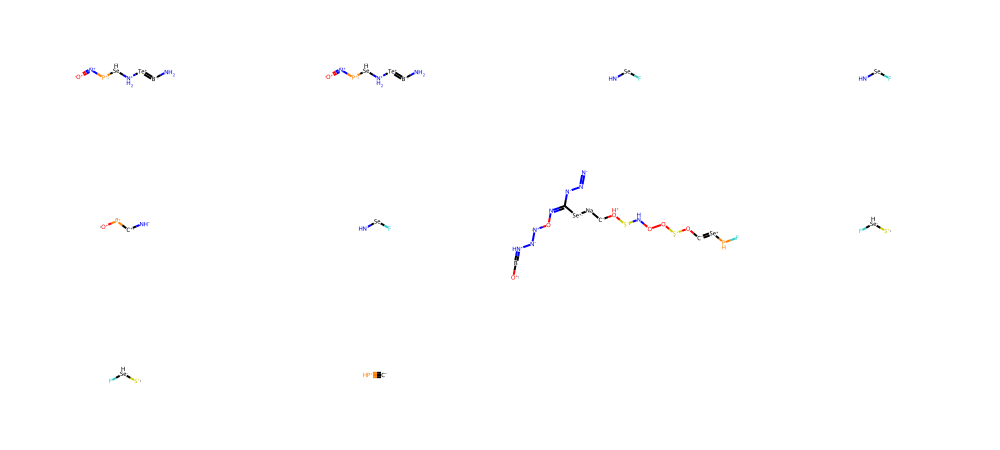

In [137]:

out = []
# model.eval()
sample_size = 10
# a = torch.ones([sample_size, 1], dtype=torch.long, device='cuda')
# a = a * vocab.vocab['<sos>']

x = torch.tensor([random.randint(0, 75) for i in range(sample_size)]).reshape([sample_size, 1]).to('cuda')
# x
out.append(x)
finish = torch.zeros(sample_size, dtype=torch.bool).to('cuda')

for _ in range(140):
    x = torch.tensor([random.randint(0, 75) for i in range(sample_size)]).reshape([sample_size, 1]).to('cuda')
# x

    out.append(x)

    eos_sampled = (x==vocab.vocab['<eos>']).data
    # print(eos_sampled.shape)
    finish = torch.logical_or(finish, eos_sampled.squeeze())
    # print(finish)
    if torch.all(finish):
        if sample_size != 1: a = torch.cat(out, 1).tolist()
        else: a = torch.cat(out).tolist()
a = [torch.cat(out).tolist()] if sample_size == 1 else torch.cat(out, 1).tolist()
# a.shape
# a = torch.cat(out, 1).tolist()
print(len(a[0]))
mols = []


for ints in a:
    s_mol = []
    for x in ints:
        if vocab.int2token[x] =='<eos>' :break
        else: s_mol.append(vocab.int2token[x])
    mols.append("".join(s_mol))
print(mols)
mols = [sf.decoder(x) for x in mols]

valid, unique = compute_valid_rate(mols)
print(f'\n valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
all_correct_molecules = set(mols)
MAX_GRID = 16
show_num = min(len(all_correct_molecules), MAX_GRID)
selected_smiles = random.choices([*all_correct_molecules], k=show_num)
molecules = [mol_conv(i) for i in selected_smiles]

img = MolsToGridImage(
    [m for m in molecules if m is not None],
    molsPerRow=int(math.sqrt(MAX_GRID)),
    subImgSize=(250, 150),  returnPNG=False)
display(img)

In [124]:
out

[tensor([ 2, 69, 12, 56,  6, 46, 44, 12,  9, 36], device='cuda:0'),
 tensor([35, 18, 74, 21, 57,  9, 23, 27, 15,  4], device='cuda:0'),
 tensor([12, 37, 37, 43, 57, 33, 67, 63, 34, 33], device='cuda:0'),
 tensor([50,  5,  4, 44, 47, 45, 64, 30, 28, 54], device='cuda:0'),
 tensor([18, 17,  9, 13, 65,  0, 31, 44, 68, 14], device='cuda:0'),
 tensor([58, 60, 67, 33, 50,  9,  6, 24, 20, 72], device='cuda:0'),
 tensor([28,  4, 43, 73,  9, 53, 15,  2, 63, 44], device='cuda:0'),
 tensor([34, 65, 23, 22, 17, 47, 43, 22,  8, 34], device='cuda:0'),
 tensor([68, 47,  9, 74, 47, 13, 56,  1, 22, 43], device='cuda:0'),
 tensor([30, 44, 21, 36, 32, 69, 54, 65, 50, 75], device='cuda:0'),
 tensor([23, 16, 31, 59, 15, 38, 68, 71,  7, 76], device='cuda:0'),
 tensor([72, 49, 40,  2, 14, 32,  5,  0,  0, 72], device='cuda:0'),
 tensor([44, 55, 64, 48, 71, 77, 67, 51, 14, 57], device='cuda:0'),
 tensor([50, 74, 76, 25, 52, 19, 47, 55, 27, 75], device='cuda:0'),
 tensor([69,  6,  1, 75, 51, 17, 66,  9, 36, 65]

14

In [ ]:
a